In [1]:
import pandas as pd

In [2]:
# semi_training_df = pd.read_pickle('semi_super_training_data_with_use_vectors_80.zip', compression='zip')

In [3]:
labeled_test_df = pd.read_pickle('training_data_with_use_vectors.zip', compression='zip')
print(len(labeled_test_df))

1571


In [4]:
from sklearn.model_selection import train_test_split
#Split the fuzzy matched records to be mixed in with training, the other half exclusively for testin
train_labeled, test_labeled = train_test_split(labeled_test_df, test_size=0.2)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import tensorflow as tf

In [6]:
#Get the labels
# training_labels = np.asarray(semi_training_df['issueArea'].to_list() + train_labeled['issueArea'].to_list())
training_labels = np.asarray(train_labeled['issueArea'].to_list())
print(len(training_labels))
print(training_labels.shape)

1256
(1256,)


In [7]:
#Document Sentences
MAX_LEN = 300
EMBEDDING_SIZE = 512  
def generate_sequences(vectors_list):
    sequence_vectors = []
    for embedding_array in vectors_list:
        diff_pad = np.max(MAX_LEN - len(embedding_array), 0)
        if diff_pad > 0:
            zeros_pad = np.array(np.zeros((diff_pad, EMBEDDING_SIZE)))
            appended = np.append(embedding_array, zeros_pad)
            resized = np.resize(appended, (MAX_LEN, EMBEDDING_SIZE))
            sequence_vectors.append(resized)
        else:
            trimmed = embedding_array[MAX_LEN:]
            resized = np.resize(trimmed, (MAX_LEN, EMBEDDING_SIZE))
            sequence_vectors.append(resized)
    return np.array(sequence_vectors)     

def merge(document_list, sentence_list): 
    return [[document_vector] + sentence_vectors for (document_vector, sentence_vectors) in zip(document_list, sentence_list)]

# document_list = semi_training_df['use_vector_document'].tolist() + train_labeled['use_vector_document'].to_list() 
# sentences_list = semi_training_df['use_vectors_sentences'].tolist() + train_labeled['use_vectors_sentences'].to_list() 
document_list = train_labeled['use_vector_document'].to_list() 
sentences_list = train_labeled['use_vectors_sentences'].to_list() 
merged_list = merge(document_list, sentences_list)
training_sequences = generate_sequences(merged_list)
print(training_sequences.shape) 

#MemoryError: Unable to allocate 52.7 GiB for an array with shape (4601, 3000, 512) and data type float64

(1256, 300, 512)


In [8]:
# def merge(lst1, lst2): 
#     return [[a] + b for (a, b) in zip(lst1, lst2)]
# lst1 = [[1,2],[5,6]]
# lst2 = [[[3,4],[3,4]],[[7,8],[7,8]]]
# print(merge(lst1, lst2))

In [9]:
#Get features and labels for the test set
test_document_list = test_labeled['use_vector_document'].tolist() 
test_sentences= test_labeled['use_vectors_sentences'].to_list()
test_merged_list = merge(test_document_list, test_sentences)
test_sequences = generate_sequences(test_merged_list)
print(test_sequences.shape) 
test_labels=test_labeled['issueArea'].tolist()


(315, 300, 512)


In [10]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(training_labels)

def encode(label_encoder, labels):
    enc = label_encoder.transform(labels)
    return tf.keras.utils.to_categorical(enc)

def decode(label_encoder, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return label_encoder.inverse_transform(dec)

In [11]:
test = encode(label_encoder, [1, 2, 7, 12,13])
print(test)
untest = decode(label_encoder, test)
print(untest)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[ 1.  2.  7. 12. 13.]


In [12]:
#Simple connected layers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Model

inputs = Input(name='inputs',shape=[MAX_LEN, 512])
dropout = Dropout(0.2)(inputs)
lstm= Bidirectional(LSTM(512))(dropout)
dense1 = Dense(1024, activation='relu')(lstm)
dropout1 = Dropout(0.2)(dense1)
# dense2 = Dense(512, activation='relu')(dropout1)
# dropout2 = Dropout(0.2)(dense2)
pred = Dense(13, activation='softmax')(dropout1)
model = Model(inputs=inputs, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 300, 512)]        0         
_________________________________________________________________
dropout (Dropout)            (None, 300, 512)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              4198400   
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                13325     
Total params: 5,261,325
Trainable params: 5,261,325
Non-trainable params: 0
___________________________________________________

In [13]:
encoded_training_labels = encode(label_encoder,training_labels)
print(len(encoded_training_labels))
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=90)
mc = ModelCheckpoint('best_model_tf_model_bidirectional_no_add_data.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(training_sequences,encoded_training_labels , epochs=150, batch_size=8, validation_split=0.2, callbacks=[mc])

1256
Train on 1004 samples, validate on 252 samples
Epoch 1/150
1000/1004 [============================>.] - ETA: 0s - loss: 1.4586 - accuracy: 0.5810
Epoch 00001: val_accuracy improved from -inf to 0.64286, saving model to best_model_tf_model_bidirectional_no_add_data.h5
1004/1004 [==============================] - 46s 45ms/sample - loss: 1.4548 - accuracy: 0.5817 - val_loss: 1.1586 - val_accuracy: 0.6429
Epoch 2/150
1000/1004 [============================>.] - ETA: 0s - loss: 1.0262 - accuracy: 0.6860
Epoch 00002: val_accuracy did not improve from 0.64286
1004/1004 [==============================] - 42s 42ms/sample - loss: 1.0265 - accuracy: 0.6863 - val_loss: 1.1642 - val_accuracy: 0.6190
Epoch 3/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.8453 - accuracy: 0.7480
Epoch 00003: val_accuracy improved from 0.64286 to 0.69841, saving model to best_model_tf_model_bidirectional_no_add_data.h5
1004/1004 [==============================] - 42s 42ms/sample - loss: 0.8451

Epoch 29/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0911 - accuracy: 0.9700
Epoch 00029: val_accuracy did not improve from 0.69841
1004/1004 [==============================] - 42s 42ms/sample - loss: 0.0951 - accuracy: 0.9691 - val_loss: 2.1864 - val_accuracy: 0.6944
Epoch 30/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9700
Epoch 00030: val_accuracy did not improve from 0.69841
1004/1004 [==============================] - 43s 42ms/sample - loss: 0.0947 - accuracy: 0.9701 - val_loss: 2.2230 - val_accuracy: 0.6706
Epoch 31/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9910
Epoch 00031: val_accuracy did not improve from 0.69841
1004/1004 [==============================] - 43s 42ms/sample - loss: 0.0303 - accuracy: 0.9910 - val_loss: 2.5067 - val_accuracy: 0.6746
Epoch 32/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980
Epoch 00032: val_accurac

1000/1004 [============================>.] - ETA: 0s - loss: 0.7727 - accuracy: 0.8180
Epoch 00056: val_accuracy did not improve from 0.70238
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.7698 - accuracy: 0.8187 - val_loss: 3.1380 - val_accuracy: 0.5317
Epoch 57/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.8530
Epoch 00057: val_accuracy did not improve from 0.70238
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.6198 - accuracy: 0.8536 - val_loss: 2.1655 - val_accuracy: 0.6349
Epoch 58/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9320
Epoch 00058: val_accuracy did not improve from 0.70238
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.2348 - accuracy: 0.9323 - val_loss: 1.8831 - val_accuracy: 0.6746
Epoch 59/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9800
Epoch 00059: val_accuracy improved fr

Epoch 84/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9890
Epoch 00084: val_accuracy did not improve from 0.71825
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.0437 - accuracy: 0.9890 - val_loss: 2.1253 - val_accuracy: 0.6865
Epoch 85/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9970
Epoch 00085: val_accuracy did not improve from 0.71825
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.0095 - accuracy: 0.9970 - val_loss: 2.2360 - val_accuracy: 0.6746
Epoch 86/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.71825
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.6241 - val_accuracy: 0.6786
Epoch 87/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000
Epoch 00087: val_accurac

Epoch 112/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.72222
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.8325 - val_accuracy: 0.7103
Epoch 113/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9950
Epoch 00113: val_accuracy did not improve from 0.72222
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.0208 - accuracy: 0.9950 - val_loss: 2.8606 - val_accuracy: 0.6865
Epoch 114/150
1000/1004 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9930
Epoch 00114: val_accuracy did not improve from 0.72222
1004/1004 [==============================] - 43s 43ms/sample - loss: 0.0255 - accuracy: 0.9930 - val_loss: 2.7620 - val_accuracy: 0.7103
Epoch 115/150
1000/1004 [============================>.] - ETA: 0s - loss: 8.4856e-04 - accuracy: 1.0000
Epoch 00115: val

Epoch 140/150
1000/1004 [============================>.] - ETA: 0s - loss: 7.6740e-04 - accuracy: 1.0000
Epoch 00140: val_accuracy did not improve from 0.72222
1004/1004 [==============================] - 44s 43ms/sample - loss: 7.6469e-04 - accuracy: 1.0000 - val_loss: 2.7079 - val_accuracy: 0.7183
Epoch 141/150
1000/1004 [============================>.] - ETA: 0s - loss: 2.6918e-04 - accuracy: 1.0000
Epoch 00141: val_accuracy did not improve from 0.72222
1004/1004 [==============================] - 44s 44ms/sample - loss: 2.6854e-04 - accuracy: 1.0000 - val_loss: 2.7267 - val_accuracy: 0.7222
Epoch 142/150
1000/1004 [============================>.] - ETA: 0s - loss: 2.6022e-04 - accuracy: 1.0000
Epoch 00142: val_accuracy did not improve from 0.72222
1004/1004 [==============================] - 44s 44ms/sample - loss: 2.5962e-04 - accuracy: 1.0000 - val_loss: 2.7767 - val_accuracy: 0.7222
Epoch 143/150
1000/1004 [============================>.] - ETA: 0s - loss: 2.3137e-04 - accuracy:

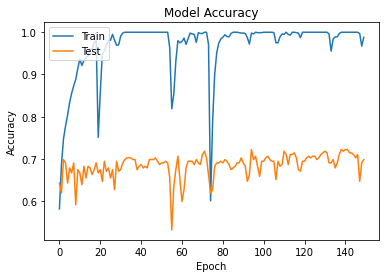

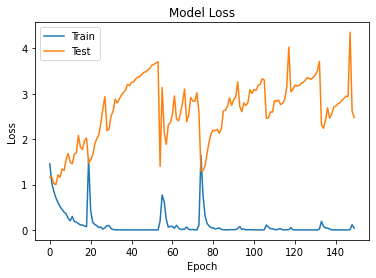

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
#save the tensorflow model
from tensorflow.keras.models import load_model
model=load_model('best_model_tf_model_bidirectional_no_add_data.h5')
performance_preds = model.predict(test_sequences)
print(performance_preds.shape)
decoded_preds = decode(label_encoder, performance_preds)
#print(decoded_preds)

(315, 13)


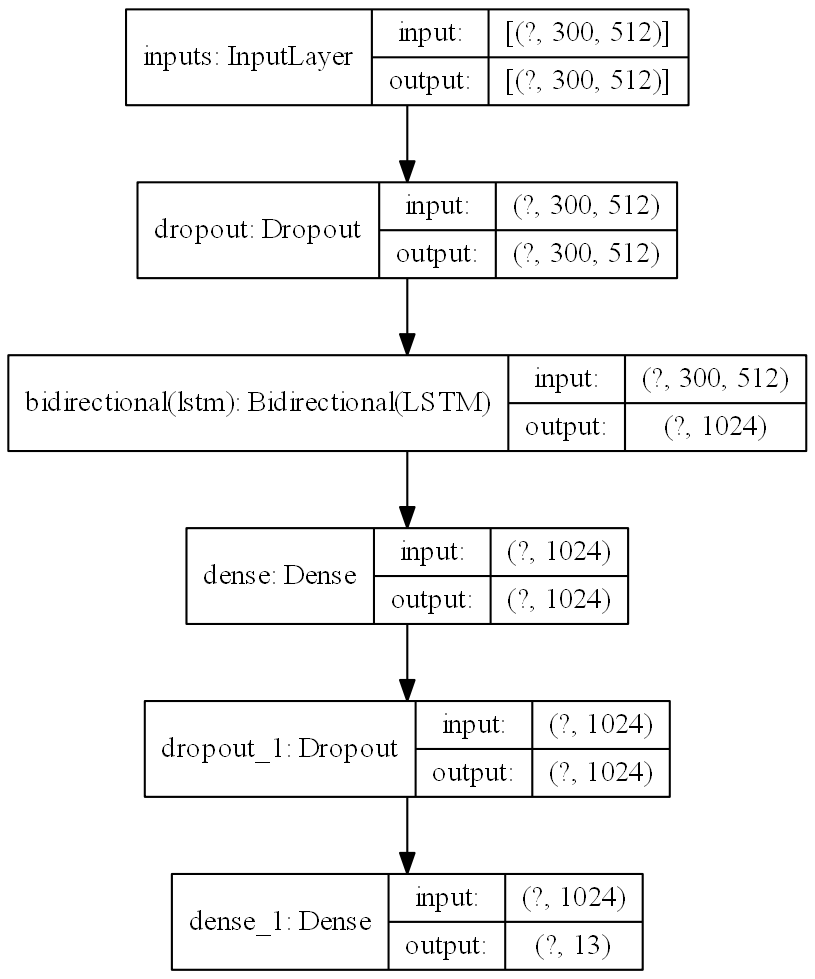

In [16]:
import pydot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
model=load_model('best_model_tf_model_bidirectional_no_add_data.h5')
plot_model(model, to_file="rnn_model.png", show_shapes=True, show_layer_names=True, expand_nested=True, dpi=150)

In [17]:
from sklearn import svm
from sklearn.metrics import classification_report
cr = classification_report(test_labels, decoded_preds)
print(cr)

              precision    recall  f1-score   support

         1.0       0.81      0.92      0.86       155
         2.0       0.67      0.44      0.53        36
         3.0       0.67      0.64      0.65        28
         4.0       0.43      0.25      0.32        12
         5.0       0.00      0.00      0.00         2
         6.0       1.00      1.00      1.00         1
         7.0       0.00      0.00      0.00         1
         8.0       0.67      0.62      0.65        32
         9.0       0.53      0.53      0.53        34
        10.0       0.50      0.17      0.25         6
        11.0       0.50      1.00      0.67         2
        12.0       0.56      0.83      0.67         6

    accuracy                           0.72       315
   macro avg       0.53      0.53      0.51       315
weighted avg       0.70      0.72      0.70       315



c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.86404834 0.53333333 0.65454545 0.31578947 0.         1.
 0.         0.64516129 0.52941176 0.25       0.66666667 0.66666667
 0.51046858 0.70388169]
[155  36  28  12   2   1   1  32  34   6   2   6 315 315]
0.6394106565155971


c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py:498: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_draw_bs_pairs" failed type inference due to: Invalid use of type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x00000247ABF04E58>)) with parameters (array(float64, 1d, C), array(float64, 1d, C), Tuple())
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x00000247ABF04E58>))
[2] During: typing of call at c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py (510)


File "..\..\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py", line 510:
    def _draw_bs_pairs(x, y):
        <source elided>
            bs_x, bs_y = x[bs_inds], y[bs_inds]
            bs_replicates[i] = f(bs_x, bs_y, args)
            ^

  @numba.jit
c:\users\u0155811\.conda\envs\t

[0.51194006 0.76461734]
0.6388816761672752
0.0006655705737473615


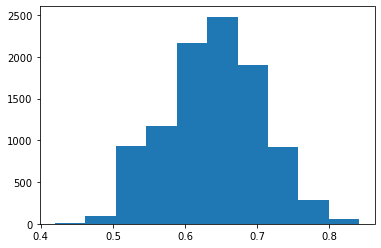

In [18]:
import ast
from scipy import stats
import dc_stat_think as dcst
import numpy as np
import matplotlib.pyplot as plt
# Add the label 13 which was missed in the splits
f1_score_list = []
support =[]
cr_dict = classification_report(test_labels, decoded_preds, output_dict=True)
for cr_value_dict in cr_dict.values():
    if isinstance(cr_value_dict, dict):
        f1_score_list.append(cr_value_dict['f1-score'])
        support.append(cr_value_dict['support'])
f1_score_np = np.array(f1_score_list)
support_np = np.array(support)
#Bootstrap sampling to calculate the confidence interval for f1-score
def weighted_average(x, y):
    return np.sum(x * y)/np.sum(y)

def boostrap_weighted_avg(data,size):
    return dcst.draw_bs_pairs(data, support, weighted_average, size=size)
   
print(f1_score_np)    
print(support_np)
print(weighted_average(f1_score_np, support_np))
bs_weighted_avg = boostrap_weighted_avg(f1_score_np, 10000)
print(np.percentile(bs_weighted_avg, [2.5, 97.5]))
print(np.mean(bs_weighted_avg))
print(stats.sem(bs_weighted_avg, axis=None, ddof=0))
plt.hist(bs_weighted_avg)
plt.show()

In [19]:
#epoch 100 f1-score 0.78 0.73 +- 0.0004
# Model: "model"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# inputs (InputLayer)          [(None, 300, 512)]        0         
# _________________________________________________________________
# bidirectional (Bidirectional (None, 1024)              4198400   
# _________________________________________________________________
# dense (Dense)                (None, 1024)              1049600   
# _________________________________________________________________
# dropout (Dropout)            (None, 1024)              0         
# _________________________________________________________________
# dense_1 (Dense)              (None, 13)                13325     
# =================================================================
# Total params: 5,261,325
# Trainable params: 5,261,325
# Non-trainable params: 0
# _________________________________________________________________